In [1]:
# importing modules

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

## The light house problem (known $\beta = 1.0$)

In [2]:
# Generate N=512 azimuths using Eq. (2.32) in Sivia
N=512
seed = 3
rng = np.random.default_rng(seed=seed)
azimuths = rng.uniform(low=-np.pi/2., high=np.pi/2., size=N)
# and corresponding x positions using Eq. (2.33) with
alpha = 1.0
beta = 1.0
xpositions = alpha + beta*np.tan(azimuths)

In [3]:
def logPrior(alpha):
    '''
    Returns the log uniform prior (-5 <= alpha <= 5)
    
    Args:
        alpha: array of floats
        
    Returns:
        logPi: (float) log prior (not necessarily normalized)
    '''
    ### BEGIN SOLUTION
    # log(1)
    logPi = np.zeros_like(alpha)
    # log(0)
    logPi[np.abs(alpha) > 5] = -np.inf
    return logPi
    ### END SOLUTION


def logLikelihood_fixed_beta(alpha, beta, x):
    '''
    Returns the log likelihood.
    
    Args:
        alpha: array of floats 
        beta: distance from shore (float)
        x: data. array of floats
        
    Returns:
        logL: (float) log likelihood (not necessarily normalized)
    '''
    ### BEGIN SOLUTION
    # Note the shapes making this Nalpha x Ndata
    delta_x_sq = (x.reshape(1,-1) - alpha.reshape(-1,1))**2
    logL_k = -np.log(beta**2 + delta_x_sq) 
    return np.sum(logL_k, axis=1)
    ### END SOLUTION

def logPosterior(alpha, beta, x):
    '''
    Return the log posterior (not necessarily normalized).
    '''
    ### BEGIN SOLUTION
    return logPrior(alpha) + logLikelihood_fixed_beta(alpha, beta, x)
    ### END SOLUTION

In [4]:
def hpd_from_grid(logpdf, x, p=0.68):
    """
    Return a HPD credible interval for a fixed grid of log(P) evaluations.

    Only works for continuous credible intervals and for equal-spaced grids.
    Warning: The returned credible interval only applies to the norm of the pdf over the provided grid.

    Arguments
    ---------
    logpdf : ndarray
        Array of log(pdf(x)) values, not necessarily normalized.
    x : ndarray
        Grid of x values (spacing must be fixed)
    p : float, default=0.68
        Credible interval percentage = p*100.

    Returns
    -------
    (lo, hi) : tuple of ints
        Low and high limit of the credible interval (indices).

    """
    dx = x[1]-x[0]
    assert np.isclose(x[1:], x[:-1]+dx).all(), "The grid must be equal spaced."
    # normalize the mode
    logpdf_norm = logpdf - logpdf.max() 
    # approximate integral to get the norm.
    norm = np.sum(np.exp(logpdf_norm))*dx
    # sorted indices (from large to small pdf)
    s = np.argsort(-np.exp(logpdf_norm))
    # Integrate from large to small pdf
    cumsum = np.cumsum(np.exp(logpdf_norm[s])*dx)/norm
    # and keep only the indices that are needed to reach p*100 percent of the total norm.
    hpd_indices = s[cumsum<p]
    hpd_indices_sorted = np.sort(hpd_indices)
    # check that the sorted indices are in a continuous range
    assert (hpd_indices_sorted[1:]-hpd_indices_sorted[:-1]==1).all(), "The interval is not continuous."
    return (hpd_indices_sorted[0], hpd_indices_sorted[-1])

Ndata =   1: mode = -2.630, 68% CI = [-3.850,-1.400], data mean = -2.626
Ndata =   2: mode = -2.140, 68% CI = [-2.710,-0.010], data mean = -1.356
Ndata =   3: mode = -0.080, 68% CI = [-1.600, 1.530], data mean = -0.108
Ndata =   8: mode =  0.500, 68% CI = [-0.180, 1.030], data mean = -0.056
Ndata =  64: mode =  1.120, 68% CI = [ 0.950, 1.280], data mean = -2.215
Ndata = 512: mode =  1.030, 68% CI = [ 0.980, 1.090], data mean =  2.628


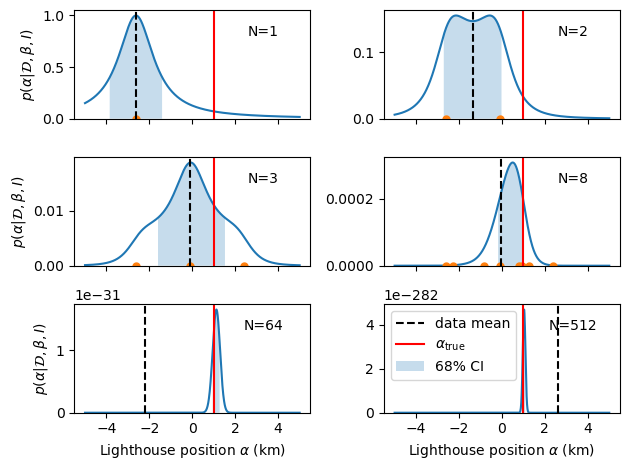

In [5]:
alphaGrid = np.linspace(-5,5,1001)
#
fig,axs = plt.subplots(3,2,sharex=True)
for iax, Nd in enumerate([1,2,3,8,64,512]):
    ax = axs.flatten()[iax]
    xpos = xpositions[:Nd]
    logP = logPosterior(alphaGrid, beta, xpos)
    # normalize the mode
    #logP -= logP.max()
    # find the 68% HPD credible interval
    (ind_lo68,ind_hi68) = hpd_from_grid(logP,alphaGrid,p=0.68)
    ax.plot(alphaGrid, np.exp(logP))
    if Nd <= 8:
        ax.plot(xpos, np.zeros(xpos.shape), 'o', ms=5);
    ax.axvline(np.mean(xpos),color='k',ls='--',label='data mean');
    ax.axvline(alpha,color='r',ls='-',label=r'$\alpha_\mathrm{true}$');
    ax.fill_between(alphaGrid[ind_lo68:ind_hi68], np.exp(logP[ind_lo68:ind_hi68]),alpha=0.25,label='68% CI')
    ax.set_ylim(ymin=0.)
    print(f'Ndata = {Nd:>3}: mode = {alphaGrid[logP.argmax()]:6.3f}, 68% CI = [{alphaGrid[ind_lo68]:6.3f},{alphaGrid[ind_hi68]:6.3f}], data mean = {np.mean(xpos):6.3f}')
    ax.text(0.8,0.8,f'N={Nd}',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r'$p(\alpha|\mathcal{D},\beta,I)$')
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel(r'Lighthouse position $\alpha$ (km)')
    #ax.set(xlabel=r'Lighthouse position $\alpha$ (km)', ylabel=r'$p(\alpha|\mathcal{D},\beta,I)$')
    ax.set_xticks([-4,-2,0,2,4])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #ax.label_outer()
axs.flatten()[-1].legend(loc='best')
fig.tight_layout()